In [7]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("OrdinaryDiffEq")

  Activating environment at `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
    Updating `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`
  [1dea7af3] + OrdinaryDiffEq v6.54.0
  No Changes to `~/all_about_robotics/julia_optimisation_course/tutorial/Manifest.toml`


In [9]:
using ControlSystemsBase
using LinearAlgebra
using Plots
import ForwardDiff as FD
using DifferentialEquations

In [80]:
# actual non linear continous dynamics of the simple pendulum

# simple pendulum paramters

m=1    # mass is of the pendulum
g=9.81 # gravity
l=1 # length of the pendulum

h=0.01 # time step for rk45 integrator

# actual dynamics
function dynamics(x,τ)
     x1,x2 =x
     x1_dot= x2
     x2_dot= -(g / l)*sin(x1)+(τ / (m*l*l))
    return [x1_dot;x2_dot]
end

#use RK45 integrator with zero order hold control
function rk45step(x,τ)
   f1=dynamics(x,τ)
   f2=dynamics(x+0.5*h*f1,τ)
   f3=dynamics(x+0.5*h*f2,τ)
   f4=dynamics(x+h*f3,τ)
    
   return x+(h/6)*(f1+2*f2+2*f3+f4)   
end


rk45step (generic function with 1 method)

In [81]:
# dynamics of the simple pendulum after feedback linearization
# it will be reduced to θ̈=u and τ=mglsin(θ)+ml²u

#state matrix and control matrix of the feedback linearized model
A_f=[0 1; 0 0]
B_f=[0;1]

#find the discrete state space of above feedback linearized model
nx=2 #number of state
nu=1 #number of control input
H = exp([A_f B_f; zeros(nu, nx + nu)]*h)
@show H[1:nx,1:nx] 
@show H[1:nx,(nx+1):(nx+nu)]

Ad=[1.0 h; 0.0 1.0]
Bd=[0.0001;h]

H[1:nx, 1:nx] = [1.0 0.01; 0.0 1.0]
H[1:nx, nx + 1:nx + nu] = [5.0e-5; 0.01]


2-element Vector{Float64}:
 0.0001
 0.01

In [82]:
#design the LQR for the feedback linerized discrete model
Q=diagm([1000,1])
R=1
K=lqr(Discrete,Ad,Bd,Q,R) #calculated the gain by using the inbuilt lqr function


1×2 Matrix{Float64}:
 30.3803  7.70346

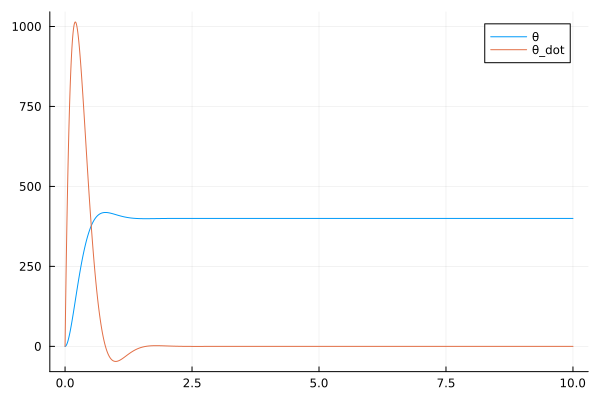

In [94]:
# move the pendulum to position of [pi/2,0] from [0,0]
x0=[0,0]
xref=[pi/18*4,0]
#
nx=2
nu=1

#problem size
tf=10
t_vec=0:h:tf
N=length(t_vec)

#states 
X=[zeros(nx) for i=1:N]
X[1]=x0

#error vector
E=[zeros(nx) for i=1:N]

E[1]=[0,0]

T=[zeros(nu) for i=1:N]
T[1]=[0]


for i = 1:N-1
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        e=(X[i]-xref)
        E[i+1]=e
        u_lqr = -K*e
        # adjust the input to cancel the non linear part of the dynamics
        τ= m*g*l*sin(X[i][1])+m*l*l*u_lqr[1]
        T[i+1]=[τ]
        #feedback linearized
        X[i+1]=rk45step(X[i],τ)
      
end
    
Xm = hcat(X...)
Em= hcat(E...)
Tm= hcat(T...)

e_cal= Xm.-xref

plot(t_vec,Xm[1,:]*(180/pi),label="θ")
plot!(t_vec,Xm[2,:]*(180/pi),label="θ_dot")




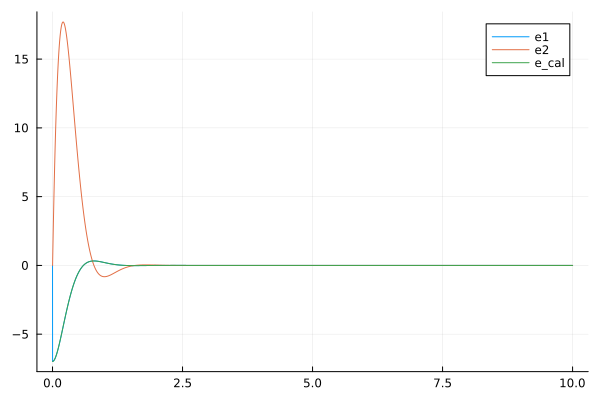

In [95]:
plot(t_vec,Em[1,:],label="e1")
plot!(t_vec,Em[2,:],label="e2")
plot!(t_vec,e_cal[1,:],label="e_cal")




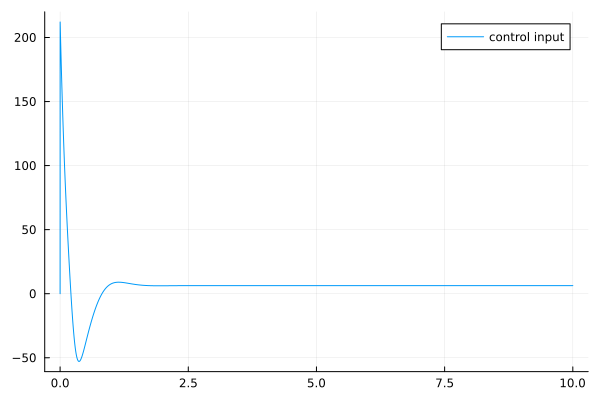

In [96]:
plot(t_vec,Tm[1,:],label="control input")

In [97]:


# actual dynamics
function dynamics(du,u,p,t)
     θ,ω =u
     g,l,τ=p
     du[1]= ω
     du[2]= -(g / l)*sin(θ)+(τ / (m*l*l))
end

dynamics (generic function with 2 methods)

In [98]:

function ode45Step(u0,τ,t,tf)
    p = (g, l, τ)  
    tspan = (t, tf)
    prob = ODEProblem(dynamics,u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    return sol
end
 

ode45Step (generic function with 2 methods)

In [99]:
sol=ode45Step([pi/18,0],0,0,)
@show sol.u[end][2]
@show sol.t[end]


(sol.u[end])[2] = -0.04208845879721708
sol.t[end] = 5.0


5.0

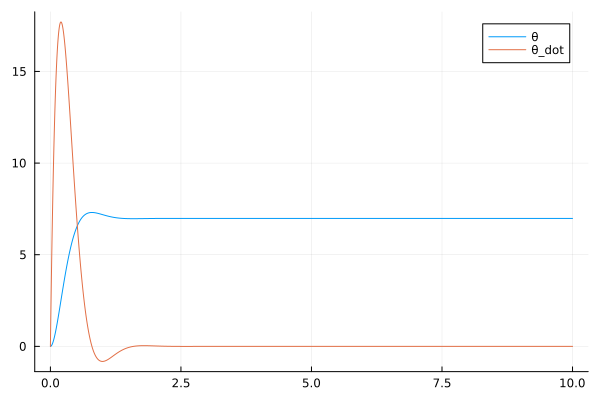

In [100]:

# move the pendulum to position of [pi/2,0] from [0,0]
#
nx=2
nu=1

#problem size
tf=10
t_vec=0:h:tf
N=length(t_vec)

#states 
X=[zeros(nx) for i=1:N]
X[1]=x0

#error vector
E=[zeros(nx) for i=1:N]

E[1]=[0,0]

T=[zeros(nu) for i=1:N]
T[1]=[0]


for i = 1:N-1
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        e=(X[i]-xref)
        E[i+1]=e
        u_lqr = -K*e
        # adjust the input to cancel the non linear part of the dynamics
        τ= m*g*l*sin(X[i][1])+(m*l*l*u_lqr[1])
        T[i+1]=[τ]
        #feedback linearized
        sol=ode45Step(X[i],τ,t_vec[i],t_vec[i+1])
        X[i+1]=sol.u[end]
      
end
    
Xm = hcat(X...)
Em= hcat(E...)
Tm= hcat(T...)

e_cal= Xm.-xref

plot(t_vec,Xm[1,:],label="θ")
plot!(t_vec,Xm[2,:],label="θ_dot")

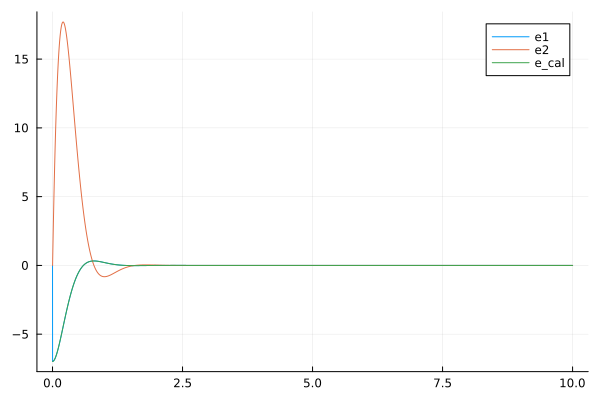

In [101]:
plot(t_vec,Em[1,:],label="e1")
plot!(t_vec,Em[2,:],label="e2")
plot!(t_vec,e_cal[1,:],label="e_cal")

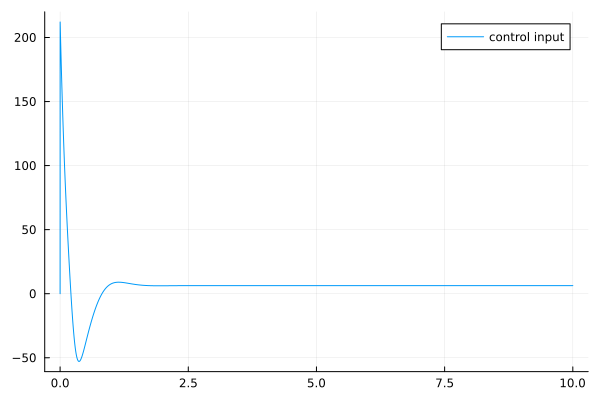

In [102]:
plot(t_vec,Tm[1,:],label="control input")